In [1]:
from graph import *

In [2]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import plotly.graph_objects as go

In [3]:
g = graph_from_spreadsheet("test_system.xlsx", functions={})

In [4]:
g.nodes

NodeView(('Detector', 'Sensors', 'Level1', 'Level2', 'Level3', 'Disk'))

In [5]:
g.graph

{'globals':    Year
 0  1992,
 'Root Node': 'Disk',
 'link power': 0.5057249999293008,
 'op power': 179999999.98252213,
 'performance': array([[9.84114051e+02, 2.60949433e-01],
        [2.60949379e-01, 1.53640506e+01]])}

In [6]:
g.nodes["Detector"]

{'sample data': 1000000,
 'sample rate': 1000,
 'type': 'detector',
 'op efficiency': 0,
 'classifier': <statistics.DummyClassifier at 0x12fa5b550>,
 'error matrix': array([[0., 0.],
        [1., 1.]]),
 'rejection ratio': 1.0,
 'data reduction': 1.0,
 'complexity': <function graph.detectors.<locals>.<lambda>(x)>,
 'global ratio': 64.0,
 'message size': 1000000,
 'ops': 1000000,
 'input rate': 1000,
 'output rate': 1000,
 'contingency': array([[  0.   ,   0.   ],
        [984.375,  15.625]]),
 'discards': array([0., 0.]),
 'energy': 0,
 'power': 0}

In [7]:
g.nodes["Sensors"]

{'classifier properties': [1, 0, 1],
 'type': 'processor',
 'rejection ratio': 1,
 'data reduction': 1.0,
 'op efficiency': 0.0,
 'sample data': 0,
 'complexity': <function graph.triggers.<locals>.<lambda>(x)>,
 'global ratio': 64,
 'message size': 1000000.0,
 'ops': 1000000.0,
 'input rate': 1000.0,
 'classifier': <statistics.Classifier at 0x12fa6e650>,
 'error matrix': array([[0., 0.],
        [1., 1.]]),
 'contingency': array([[  0.   ,   0.   ],
        [984.375,  15.625]]),
 'discards': array([0., 0.]),
 'output rate': 1000.0,
 'energy': 0.0,
 'power': 0.0}

In [8]:
g.nodes["Level1"]

{'classifier properties': [2, 3, 1],
 'type': 'processor',
 'rejection ratio': 2,
 'data reduction': 1.0,
 'op efficiency': 0.03,
 'sample data': 0,
 'complexity': <function graph.triggers.<locals>.<lambda>(x)>,
 'global ratio': 64,
 'message size': 1000000.0,
 'ops': 1000000.0,
 'input rate': 1000.0,
 'classifier': <statistics.Classifier at 0x12fa6e800>,
 'error matrix': array([[0.50791364, 0.00144048],
        [0.49208636, 0.99855952]]),
 'contingency': array([[4.99977493e+02, 2.25074883e-02],
        [4.84397507e+02, 1.56024925e+01]]),
 'discards': array([4.99977493e+02, 2.25074883e-02]),
 'output rate': 499.9999999417404,
 'energy': 30000.0,
 'power': 30000000.0}

In [9]:
g.nodes["Level1"]["classifier"].error_matrix

array([[0.50791364, 0.00144048],
       [0.49208636, 0.99855952]])

In [10]:
g.nodes["Level2"]

{'classifier properties': [4, 4, 1],
 'type': 'processor',
 'rejection ratio': 4,
 'data reduction': 1.0,
 'op efficiency': 0.3,
 'sample data': 0,
 'complexity': <function graph.triggers.<locals>.<lambda>(x)>,
 'global ratio': 32,
 'message size': 1000000.0,
 'ops': 1000000.0,
 'input rate': 499.9999999417404,
 'classifier': <statistics.Classifier at 0x12fa5b5e0>,
 'error matrix': array([[7.74138823e-01, 5.82213866e-04],
        [2.25861177e-01, 9.99417786e-01]]),
 'contingency': array([[3.74990916e+02, 9.08398748e-03],
        [1.09406591e+02, 1.55934085e+01]]),
 'discards': array([3.74990916e+02, 9.08398748e-03]),
 'output rate': 124.9999997587255,
 'energy': 300000.0,
 'power': 149999999.98252213}

In [11]:
g.nodes["Level3"]

{'classifier properties': [8, 5, 1],
 'type': 'processor',
 'rejection ratio': 8,
 'data reduction': 1.0,
 'op efficiency': 0.0,
 'sample data': 0,
 'complexity': <function graph.triggers.<locals>.<lambda>(x)>,
 'global ratio': 8,
 'message size': 1000000.0,
 'ops': 1000000.0,
 'input rate': 124.9999997587255,
 'classifier': <statistics.Classifier at 0x12fa5b4c0>,
 'error matrix': array([[0.99761487, 0.01470865],
        [0.00238513, 0.98529135]]),
 'contingency': array([[109.14564186,   0.22935796],
        [  0.26094938,  15.36405057]]),
 'discards': array([109.14564186,   0.22935796]),
 'output rate': 15.624999946037715,
 'energy': 0.0,
 'power': 0.0}

In [12]:
g.edges[("Level1", "Level2")]

{'link efficiency': 2.5e-11,
 'statistics': array([484.39750743,  15.60249251]),
 'message size': 1000000.0,
 'throughput': 499999999.9417404,
 'energy': 0.0002,
 'power': 0.09999999998834808}

In [13]:
g.graph

{'globals':    Year
 0  1992,
 'Root Node': 'Disk',
 'link power': 0.5057249999293008,
 'op power': 179999999.98252213,
 'performance': array([[9.84114051e+02, 2.60949433e-01],
        [2.60949379e-01, 1.53640506e+01]])}

In [14]:
from metrics import *

In [15]:
recall(g.graph["performance"])

0.9832992362597975

In [16]:
detectors, triggers, globals = dataframes_from_spreadsheet("test_system.xlsx")

In [17]:
triggers

,Name,Output,Data (bytes),Reduction,Skill mean,Skill variance,Link Efficiency (J/bit),Op Efficiency (J/op),Compression
0,Sensors,Level1,0,1,0,1,2.500000e-11,0.00,0
1,Level1,Level2,0,2,3,1,2.500000e-11,0.03,0
2,Level2,Level3,0,4,4,1,2.500000e-11,0.30,0
3,Level3,Disk,0,8,5,1,2.500000e-11,0.00,0
4,Disk,NaN,0,1,0,1,2.500000e-11,0.00,0


In [32]:
def vary_lv1(reduction):
    total_reduction = 2 * 4
    t = triggers.copy()

    t.at[1, "Reduction"] = total_reduction / reduction
    t.at[2, "Reduction"] = reduction
    g = construct_graph(detectors, t, globals, {})

    power = g.graph["op power"] + g.graph["link power"]
    r = recall(g.graph["performance"])
    
    return (power, r)

In [33]:
vary_lv1(2)

(104999999.89612499, 0.9775326629621337)

In [39]:
xs = np.linspace(2.0, 8.0, 51)

In [40]:
res = [vary_lv1(x) for x in xs]

In [41]:
res_p = np.array([r[0] for r in res])
res_r = np.array([r[1] for r in res])

Text(0, 0.5, 'Power')

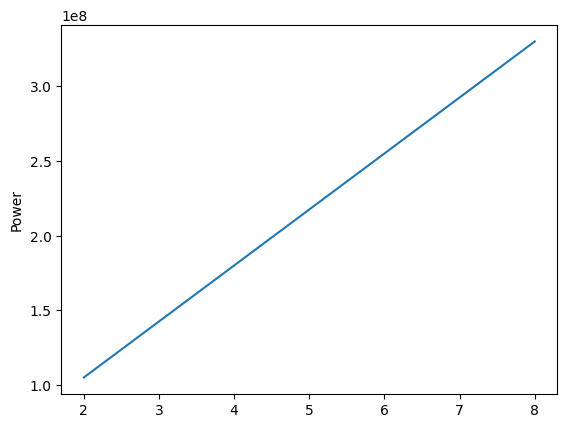

In [42]:
plt.plot(xs, res_p)
plt.ylabel("Power")

Text(0, 0.5, 'Recall')

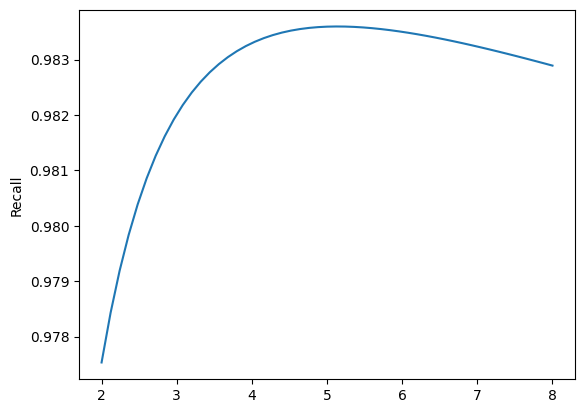

In [43]:
plt.plot(xs, res_r)
plt.ylabel("Recall")